# Introduction

This tutorial has https://github.com/jonhare/DISCnetMachineLearningCourse/blob/master/Monday/ml101-tutorial/tutorial.md as a starting point.

For the completion of this tutorial, you need to be comfortable with basic python. It is organised as follows:
- loading and understanding the structure of the dataset 
- feature extraction: Bag of Words
- introduction in sklearn to:
    * unsupervised methods: K-Means
    * supervised methods: KNN and SVM
- parameter tuning: grid search
- dealing with data: unbalanced datasets

Although we present the core idea of the three algorithms, we strongly encourage you to have a closer look at the theoretical aspect, especially in the case of SVMs. 
 
 We will work with the "Twenty Newsgroups" dataset, which consists of roughly 20K documents belonging to 20 (balanced) newsgroups.
The dataset is available at https://github.com/ecs-vlc/ml_workshop_2019/raw/master/scikit-learn/data.zip.
We can use the urllib module to download the "data.zip" file from the given URL, which we then decompress.

In [1]:
import urllib.request
urllib.request.urlretrieve("https://github.com/ecs-vlc/ml_workshop_2019/raw/master/scikit-learn/data.zip", "data.zip")

import zipfile
zip_ref = zipfile.ZipFile("data.zip", 'r')
zip_ref.extractall()
zip_ref.close()

After successfully running the code above, you should now see in your current working directory the "data" folder. Note that for this part we are only interested in one of the subdirectories: "data/twenty_newsgroups". You can navigate through it and familiarise yourself with the structure of the data set. The data is split into training and testing. Within each of the training and testing folders are 20 folders representing the 20 different newsgroups. Within these folders are the actual messages posted on the newsgroups, with one file per message. You are encouraged to spend some time to open a few of the files in a text editor to see their contents.  

Before loading the data set, let us initially choose a subset of only 4 categories out of the 20 available for faster execution times.

In [2]:
from sklearn.datasets import load_files

categories = ['alt.atheism', 'soc.religion.christian', 'comp.graphics', 'sci.med']
twenty_train = load_files('data/twenty_newsgroups/train',categories=categories, shuffle=True, random_state=42, encoding='latin1')

The returned dataset is a `scikit-learn` "bunch": a simple holder object with fields that can be both accessed as python `dict` keys or `object` attributes for convenience, for instance the `target_names` holds the list of the requested category names:

In [3]:
print(twenty_train.target_names)

['alt.atheism', 'comp.graphics', 'sci.med', 'soc.religion.christian']


The files themselves are loaded in memory in the data attribute. Let us check that the number of training examples is 2257.

In [4]:
print(len(twenty_train.data))

2257


Today we will look at both supervised (assigning each example to a known, given class. In our case, one of the four categories we selected) and unsupervised learning (classifying data points as belonging to a "conceptual" class which we identify in our data set. This concept will hopefully become clearer later on).

Supervised learning algorithms will require a category label for each document in the training set, which is our target. For speed and space efficiency reasons scikit-learn loads the target attribute as an array of integers that corresponds to the index of the category name in the target_names list. The category integer ID of each sample is stored in the target attribute. As an example, we print the labels of the first 15 training examples: 

In [5]:
print(twenty_train.target[:15])

[1 0 2 2 0 1 1 3 3 2 1 0 1 1 1]


You can notice that the samples have been shuffled randomly (with a fixed random number generator seed), as when loading the files we set the `shuffle` attribute to `True`. 
This is useful if you select only the first samples to quickly train a model and get a first idea of the results before re-training on the complete dataset. We will make use of this later on in our tutorial.

For this data set, the category is the name of the newsgroup which also happens to be the name of the folder holding the individual documents. 
Check that this is the case for the first example in our training data. 
In the code block below, print the file name (use the `filenames` attribute) and the label of the first training example. As seen above, the target attribute stores an ID. To link that ID to a category name, use the `target_names` attribute.  

So now we know which class the first example belongs to. Let us have a look at its first lines.

In [6]:
print("\n".join(twenty_train.data[0].split("\n")[:20]))

From: clipper@mccarthy.csd.uwo.ca (Khun Yee Fung)
Subject: Re: looking for circle algorithm faster than Bresenhams
Organization: Department of Computer Science, The University of Western
	Ontario, London, Ontario, Canada
In-Reply-To: graeme@labtam.labtam.oz.au's message of Wed, 14 Apr 1993 04:49:46 GMT
	<1993Apr13.025240.8884@nwnexus.WA.COM>
	<1993Apr14.044946.12144@labtam.labtam.oz.au>
Nntp-Posting-Host: mccarthy.csd.uwo.ca
Lines: 41

>>>>> On Wed, 14 Apr 1993 04:49:46 GMT, graeme@labtam.labtam.oz.au (Graeme Gill) said:

Graeme> 	Yes, that's known as "Bresenhams Run Length Slice Algorithm for
Graeme> Incremental lines". See Fundamental Algorithms for Computer Graphics,
Graeme> Springer-Verlag, Berlin Heidelberg 1985.

> I have tried to extrapolate this to circles but I can't figure out
> how to determine the length of the slices. Any ideas?

Graeme> 	Hmm. I don't think I can help you with this, but you might


Now that we familiarised ourselves with the dataset, let's extract some features.

# Feature extraction: Bag of Words (BoW)


To feed text to our machine learning algorithm, we need to turn the text content into numerical, fixed-length feature vectors. The most intuitive way to do so is the _Bags of Words_ (BoW) representation. A bag is simply a set that allows repetitions.

When building a BoW the first step is to break the text into its constituent words, which we refer to as _tokenisation_ and then count the number of times each word in our corpus appears in a document. With `scikit-learn` we can easily transform texts to feature vectors and then get the desired count using a `CountVectorizer`.

The `CountVectorizer` produces a sparse representation, as the bag of words implies that `n_features` is the number of distinct words in the corpus: this number is typically larger that 100,000. But most counts will be zero, as a given text usually contains a limited vocabulary. We can save a lot of memory by only storing the non-zero parts of the feature vectors in memory. 

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(twenty_train.data)
print(X_train_counts.shape)

(2257, 35788)


Our `X_train_counts` holds a term-document matrix which counts the number of times each of the 35788 features is present in each of the 2257 texts. CountVectorizer also supports counts of N-grams of words or consecutive characters. N-grams are runs of consecutive characters or words, so for example in the case of word bi-grams, every consecutive pair of words would be a feature. 

Once fitted, the vectorizer has built a dictionary of feature indices in which you can search a term to get its ID. Use the code block below to find the number of times the term 'algorithm' is present in the first document. 

Now we have a fixed integer ID for each word occurring in any document of the training set and for each document, we have a count of occurrences of each word. One problem with the simple count of occurrences is that it does not account for the document length. Instead, we can calculate the _term frequency_ (tf), which is simply the ratio of the number of times a word occurs in a text and the total number of terms in that text.

Another important aspect we want to account for is that words are not equally informative. We want to prioritise words that are less frequent across different texts, as they are more likely to indicate the topic. We can do this by weighting the terms according to their _inverse document frequency_ (idf): the number of documents divided by the number of documents a word appears in.

`Scikit-learn` allows us to combine these two refinements into what is referred to as "Term Frequency-Inverse Document Frequency" (tf–idf).

In [8]:
from sklearn.feature_extraction.text import TfidfTransformer
tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)
print(X_train_tf.shape)

(2257, 35788)


Let us print out the scores corresponding the words in the first document.

In [9]:
print(X_train_tf[0])

  (0, 98)	0.03566881875032108
  (0, 124)	0.07133763750064216
  (0, 137)	0.03566881875032108
  (0, 336)	0.03566881875032108
  (0, 448)	0.03566881875032108
  (0, 587)	0.07133763750064216
  (0, 1093)	0.03566881875032108
  (0, 1095)	0.03566881875032108
  (0, 1097)	0.03566881875032108
  (0, 1101)	0.03566881875032108
  (0, 1102)	0.07133763750064216
  (0, 1118)	0.03566881875032108
  (0, 1119)	0.03566881875032108
  (0, 1690)	0.03566881875032108
  (0, 1723)	0.03566881875032108
  (0, 1989)	0.03566881875032108
  (0, 1996)	0.03566881875032108
  (0, 2044)	0.03566881875032108
  (0, 2079)	0.03566881875032108
  (0, 2203)	0.03566881875032108
  (0, 2303)	0.07133763750064216
  (0, 2350)	0.07133763750064216
  (0, 2427)	0.07133763750064216
  (0, 2513)	0.03566881875032108
  (0, 2562)	0.03566881875032108
  :	:
  (0, 32131)	0.03566881875032108
  (0, 32139)	0.03566881875032108
  (0, 32142)	0.14267527500128432
  (0, 32253)	0.03566881875032108
  (0, 32270)	0.07133763750064216
  (0, 32439)	0.03566881875032108
  (

In the code block below, find the words corresponding to the first two non-zero entries; that is, words with IDs 2044 and 14085. Reflect on why they might have small weights relating back to both term frequency and inverse document frequency. Also, identify the word with the highest score.

Rather than transforming the raw counts with the `TfidfTransformer`, it is alternatively possible to use the `TfidfVectorizer` to directly parse the dataset. The advantage of doing this is that it can automatically filter out less informative words on the basis of stop-words, document frequency, etc.:

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer(stop_words='english',max_df=0.5,min_df=2)
X_train_tfidf = tfidf_vect.fit_transform(twenty_train.data)
print(X_train_tfidf.shape)

(2257, 18188)


As you can see from the output, the number of features was reduced from 35788 to 18188 using this approach. We will use these features for all of the algorithms that we will look at today, starting with K-means.

# K-Means clustering

To better understand unsupervised learning and also to get a better understanding of our dataset, for this section we will pretend we don't know what the possible classes are. That is, we will ignore the labels and experiment with clustering, which essentially means grouping data points based on a similarity measure. We'll use K-Means as its one of the most intuitive clustering methods, although it does have a few limitations This blog (https://www.inovex.de/blog/disadvantages-of-k-means-clustering/) discusses it in the context of anomaly detection but does a good job of highlighting some of the issues. 

If you are unfamiliar with the K-means algorithm, the Wikipedia page (https://en.wikipedia.org/wiki/K-means_clustering) provides a clear description and an illustration of how it works. The idea is to find K clusters in the data in an unsupervised manner. Each cluster has a _centroid_ (mean).
Means are initialised randomly and then, until convergence, data points are assigned to the closest group and centroids are updated.

We initially perform K-means with `k_clusters = 4` clusters as we restricted our data to 4 categories, but we will get to experiment with different values. An important aspect to remember is that K-means has a random initialisation element to the algorithm. You can choose to set the `random_state` if you want.


In [11]:
from sklearn.cluster import KMeans
k_clusters = 4
km = KMeans(k_clusters)
km.fit(X_train_tfidf)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

The assignments of the original posts to cluster ID is given by `km.labels_` once `km.fit(..)` has been called. The array of cluster centroids is given by `km.cluster_centers_`. Intuitively, the vector that describes the centre of a cluster is just like any other featurevector. Every element can be interpreted as the number of times a specific term occurs (or the tf-idf weight of a specific term) in a hypothetical document. An interesting way to explore what each cluster is representing is to calculate and print the top weighted (either by the occurrence or tf-idf) terms for that cluster:

In [12]:
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vect.get_feature_names()
for i in range(k_clusters):
    print("Cluster %d:" % i, end="")
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end="")
    print()

Cluster 0: god jesus people believe bible christians faith christian hell christ
Cluster 1: pitt geb banks gordon cs cadre dsl shameful n3jxp surrender
Cluster 2: com university article posting graphics host nntp know like msg
Cluster 3: keith caltech livesey sgi wpd solntze schneider jon cco morality


A number of different metrics exist that allow us to measure how well the clusters fit the known distribution of underlying newsgroups.

In [13]:
from sklearn import metrics
print("Homogeneity: %0.3f" % metrics.homogeneity_score(twenty_train.target, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(twenty_train.target, km.labels_))

Homogeneity: 0.258
Completeness: 0.421


Homogeneity and completeness are measures between 0 and 1. A homogeneity of 1 indicates that the clusters match the original labels exactly. Completeness of 1 means that all members of one class are assigned to the same centroid. Experiment with how different values of `k_clusters` influence the two.

Finally, print out the targets (which you don't normally have in an unsupervised setting) and the identified labels. 


Now identify the cluster to which the 10th training example was attributed to using `km.labels_`, the target and the name of that target. `KMeans` simply outputs a label, which is an integer. As a supervised method, it does not immediately identify the label with one of the four categories. On the other hand, for the target, as we have seen above, we can go from an integer to a class name in a straightforward manner.

# Building a predictive model using K-nearest Neighbours (KNN)

Moving to supervised methods, we train a classifier to try to predict the category of a post. Let's start with a KNN classifier, which provides a simple baseline, although is perhaps not the best classifier for this task. Essentially, KNN associates each instance to the same class as the majority of its k neighbours in the feature space.

In [14]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=3).fit(X_train_tfidf, twenty_train.target)

To try to predict the outcome on a new document we need to extract the features using almost the same feature extracting chain as before. The difference is that we call transform instead of fit_transform on the transformers/vectorizers since they have already been fitted to the training set:

In [15]:
docs_new = ['God does not exist', 'God exists' , 'The procedure is non-invasive' , 'These are 24 bit color images.']
X_new_tfidf = tfidf_vect.transform(docs_new)

predicted = clf.predict(X_new_tfidf)
for doc, category in zip(docs_new, predicted):
    print('%r => %s' % (doc, twenty_train.target_names[category]))

'God does not exist' => alt.atheism
'God exists' => soc.religion.christian
'The procedure is non-invasive' => sci.med
'These are 24 bit color images.' => comp.graphics


In order to make the vectorizer => [transformer] => classifier easier to work with, `scikit-learn` provides a `Pipeline` class that behaves like a compound classifier:

In [16]:
from sklearn.pipeline import Pipeline
text_clf_KNN = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', KNeighborsClassifier(n_neighbors=3))])

We can now train the model with a single command:

In [17]:
text_clf_KNN = text_clf_KNN.fit(twenty_train.data, twenty_train.target)

Next, we evaluate the accuracy given by the average number of correct predictions divided by the number of total predictions.

In [18]:
import numpy as np
twenty_test = load_files('data/twenty_newsgroups/test', categories=categories, shuffle=True, random_state=42, encoding='latin1')
predicted = text_clf_KNN.predict(twenty_test.data)
np.mean(predicted == twenty_test.target)

0.7723035952063915

This means we achieved a 77.2% accuracy. Let's see if we can do better with a linear support vector machine (SVM), which is widely regarded as one of the best text classification algorithms (when used with suitable features). 
The main idea of SVMs is to find a separating hyperplane that gives the largest margin between the classes. Have a look at this article to get an intuition on margins: https://towardsdatascience.com/support-vector-machine-introduction-to-machine-learning-algorithms-934a444fca47.

We can change the learner by just plugging a different classifier object into our pipeline. Note that we also save the accuracy, as we will need it later on.

In [19]:
from sklearn.linear_model import SGDClassifier
text_clf_SVM = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', SGDClassifier(loss='hinge', penalty='l2',
                                           alpha=1e-3, max_iter=5, tol=None,
                                           random_state=42)),
])
_ = text_clf_SVM.fit(twenty_train.data, twenty_train.target)
predicted_SVM = text_clf_SVM.predict(twenty_test.data)
acc_SVM = np.mean(predicted_SVM == twenty_test.target)
print(acc_SVM)

0.9081225033288948


                        precision    recall  f1-score   support

           alt.atheism       0.59      0.88      0.70       319
         comp.graphics       0.92      0.80      0.86       389
               sci.med       0.89      0.61      0.73       396
soc.religion.christian       0.79      0.82      0.80       398

           avg / total       0.81      0.77      0.78      1502



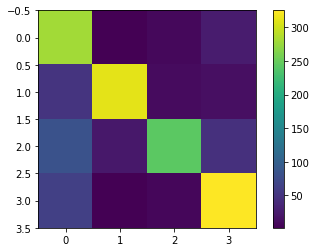

In [20]:
from sklearn import metrics
import matplotlib.pyplot as plt

print(metrics.classification_report(twenty_test.target, predicted, target_names=twenty_test.target_names))
im = plt.imshow(metrics.confusion_matrix(twenty_test.target, predicted), interpolation='nearest')
plt.colorbar(im)
plt.show()

The confusion matrix shows that posts from the newsgroups on atheism and christianity are more often confused for one another.

## Parameter tuning using grid search

We've already encountered some parameters such as `use_idf` in the `TfidfTransformer` (and `TfidfVectorizer`). Classifiers tend to have many parameters as well; e.g., `KNeighborsClassifier` includes parameter for the number of neighbours and `SGDClassifier` has a penalty parameter `alpha` and configurable loss and penalty terms in the objective function (see the module documentation, or use the Python help function, to get a description of these).

Instead of tweaking the parameters of the various components of the chain, it is possible to run an exhaustive search of the best parameters on a grid of possible values. Let's use this to explore whether we can make the `KNeighborsClassifier` perform as well as our linear SVM. We'll try out classifiers on either words or bi-grams, with or without idf, and with a K (number of neighbours) ranging from 1 to 7 (odd numbers only):

In [21]:
from sklearn.model_selection import GridSearchCV
parameters = {'tfidf__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf': (True, False),
              'clf__n_neighbors': (1, 3, 5, 7)
}

Obviously, such an exhaustive search can be expensive. If we have multiple CPU cores at our disposal, we can tell the grid searcher to try these eight parameter combinations in parallel with the `n_jobs` parameter. If we give this parameter a value of -1, grid search will detect how many cores are available and use them all:

In [22]:
gs_clf = GridSearchCV(text_clf_KNN, parameters, n_jobs=-1)

The grid search instance behaves like a normal scikit-learn model. Let's perform the search on a smaller subset of the training data to speed up the computation:

In [42]:
train_size = 400
gs_clf = gs_clf.fit(twenty_train.data[:train_size], twenty_train.target[:train_size])

The result of calling `fit` on a `GridSearchCV` object is a classifier that we can use to `predict`:

In [43]:
twenty_train.target_names[gs_clf.predict(['God is love'])[0]]

'alt.atheism'

Note that `predict` returns an array of predictions, as we usually want to get predictions for multiple examples at a time, so to get the target name, we need to get the first of our predictions. The object’s `best_score_` and `best_params_` attributes store the best mean score and the parameters setting corresponding to that score:

In [25]:
print(gs_clf.best_score_)

0.7


In [26]:
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

clf__n_neighbors: 5
tfidf__ngram_range: (1, 2)
tfidf__use_idf: True


Try using `GridSearchCV` together with the `SGDClassifier` SVM classifier we defined above to find the optimal `alpha`, together with the optimal `ngram` range and use idf parameters for the vectoriser. How does the classification accuracy compare to the K-Nearest-Neighbours classifier? How does the performance change if we increase the `train_size`?

Can you build a classifier for the entire 20 class dataset? What is the performance, and how does it compare to the 4 classes we have been experimenting with?

# Unbalanced datasets

From the point of view of data distribution, the dataset we've been working with is very convenient. We extend the original dataset with a new class, which we call `alt.atheism.reduced`, to explore the difficulties that can arise with unbalanced datasets. This new class only contains a small fraction of the original `alt.atheism` category.

We start by reminding ourselves what accuracy we obtained using the SVM.

In [27]:
print(acc_SVM)

0.9081225033288948


Next, we load again the data belonging to the same four categories, except `alt.atheism`, which we replace with the new class and then use the same pipeline as before to obtain our predictions.

In [28]:
categories_un = ['alt.atheism.reduced', 'soc.religion.christian', 'comp.graphics', 'sci.med']
twenty_train_un = load_files('data/twenty_newsgroups/train',categories=categories_un, shuffle=True, random_state=42, encoding='latin1')
_ = text_clf_SVM.fit(twenty_train_un.data, twenty_train_un.target)
twenty_test_un = load_files('data/twenty_newsgroups/test', categories=categories_un, shuffle=True, random_state=42, encoding='latin1')
predicted_un = text_clf_SVM.predict(twenty_test_un.data)
print(np.mean(predicted_un == twenty_test_un.target))

0.9332220367278798


We observe a slight improvement in accuracy. Let's take a closer look at our predictions.

In [29]:
print(metrics.classification_report(twenty_test_un.target, predicted_un, target_names=twenty_test_un.target_names))

                        precision    recall  f1-score   support

   alt.atheism.reduced       1.00      0.27      0.42        15
         comp.graphics       0.89      0.98      0.93       389
               sci.med       0.98      0.89      0.93       396
soc.religion.christian       0.94      0.96      0.95       398

           avg / total       0.94      0.93      0.93      1198



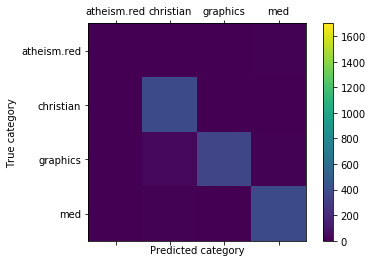

In [41]:
labels = ["atheism.red", "christian", "graphics", "med"]
cm = metrics.confusion_matrix(twenty_test_un.target, predicted_un)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm, vmin = 0, vmax = 1700)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted category')
plt.ylabel('True category')
plt.show()

What happened here? As we have seen, with the original dataset the separation between `alt.atheism` and `soc.religion.christian` was not very clear and having an overwhelming number of examples from one of the classes made the two groups even less distinguishable. Yet, the accuracy has increased. For this reason, we must be very careful when choosing a metric, as it can be misleading. In the case of unbalanced datasets, the AUROC (Area under reciever operator characteristic) and AUPR (Area under precision recall) curves are more indicative of how well we perform on unseen data.

Think about having to diagnose whether patients have a rare disease or not. Naturally, we would have more data about healthy patients. If we do not choose our measure of performance carefully, our machine might end up labelling all patients as healthy, as it is more probable that a person does not suffer of a rare disease. In the case of newsgroup classification, the fact that the classifier cannot distinguish the two categories doesn't seem that much of a problem. However a medical classifier not being able to identify ill patients would be more problematic.
 
This article (https://towardsdatascience.com/handling-imbalanced-datasets-in-machine-learning-7a0e84220f28) extensively explains the problem both intuitively and from a statistical point of view and point out some limitations of the popular work-around methods. The same article discusses confusion matrices, precision, recall and F1.


# Sentiment analysis prediction

Now it's your turn to build a classification pipeline to predict whether a review is negative or positive.

In [31]:
dataset = load_files('data/movie_reviews/txt_sentoken')

This time, the data does not come with training and testing data so we will need to do the split ourselves.

In [32]:
from sklearn.model_selection import train_test_split

docs_train, docs_test, y_train, y_test = train_test_split(
        dataset.data, dataset.target, test_size=0.25, random_state=None)

Now our reviews are stored in `doc_train` and `doc_test`, while the targets are in `y_train` and `y_test`. Build a classification pipeline that filters uninformative terms.

Use grid search to decide between using unigrams or bigrams. 

Make predictions on the test data and print the classification report